In [1]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"


import itertools 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
train_data_dir = '../input/breastcancerlaisonsplit/split/split/train'
validation_data_dir = '../input/breastcancerlaisonsplit/split/split/val'
test_Data_dir='../input/breastcancerlaisonsplit/split/split//val'

num_classes = 2
batch_size = 16
img_rows, img_cols = 224, 224
INPUT_SHAPE = (img_rows, img_cols, 3)

train_datagen = ImageDataGenerator(rotation_range=90, zoom_range=0.15, width_shift_range=0.2,
            height_shift_range=0.2, shear_range=30, horizontal_flip=True, fill_mode="nearest")

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory( validation_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
test_generator=test_datagen.flow_from_directory( test_Data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')

Found 624 images belonging to 2 classes.
Found 156 images belonging to 2 classes.
Found 156 images belonging to 2 classes.


In [32]:
def modelfunction(pretrained, weight):
    
    for layer in pretrained.layers:
        layer.trainable = False
        
    def addTopModel(bottom_model, num_classes):
        top_model = bottom_model.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dense(num_classes, activation='softmax')(top_model)
        return top_model
    
    FC_Head = addTopModel(pretrained, num_classes)
    model = Model(inputs=pretrained.input, outputs=FC_Head)
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    
    metrics = ['accuracy', tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes), 
               tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    
    batch_size = 32
    
    class_weights = class_weight.compute_class_weight( 'balanced', classes = np.unique(train_generator.classes),  y =train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    history = model.fit_generator(train_generator, steps_per_epoch=624  // batch_size, epochs= 100, callbacks=callbacks, validation_data=validation_generator, 
                              validation_steps=156  // batch_size, class_weight = train_class_weights)
    
    #plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    test_score = model.evaluate_generator(test_generator, batch_size)
    print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
    print("[INFO] Loss: ",test_score[0])
    
   
    #shuffle=False
    target_names = []
    for key in train_generator.class_indices:
        target_names.append(key)

    #Confution Matrix
    Y_pred = model.predict_generator(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_generator.classes, y_pred)
    print(cm)
    
    #plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
    #Print Classification Report
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 11s 467ms/step - loss: 1.3009 - accuracy: 0.5724 - auc_11: 0.6116 - cohen_kappa: -0.6746 - f1_score: 0.4692 - precision_11: 0.5724 - recall_11: 0.5724 - val_loss: 0.5021 - val_accuracy: 0.7812 - val_auc_11: 0.8733 - val_cohen_kappa: -0.3581 - val_f1_score: 0.5852 - val_precision_11: 0.7812 - val_recall_11: 0.7812

Epoch 00001: val_loss improved from inf to 0.50212, saving model to MobileNet.h5
Epoch 2/100
19/19 [==============================] - 7s 379ms/step - loss: 0.7484 - accuracy: 0.4770 - auc_11: 0.4723 - cohen_kappa: -0.8794 - f1_score: 0.4411 - precision_11: 0.4770 - recall_11: 0.4770 - val_loss: 0.7692 - val_accuracy: 0.4375 - val_auc_11: 0.4758 - val_cohen_kappa: -1.0000 - val_f1_score: 0.4375 - val_precision_11: 0.4375 - val_recall_11: 0.4375

Epoch 00002: val_loss did not improve from 0.50212
Epoch 3/100
19/19 [==============================] - 8s 417ms/step - loss: 0.6702 - accuracy: 0.5855 - auc_11: 0.7026 - cohen_kappa

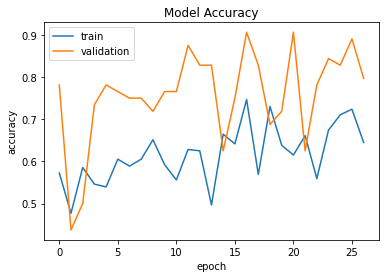

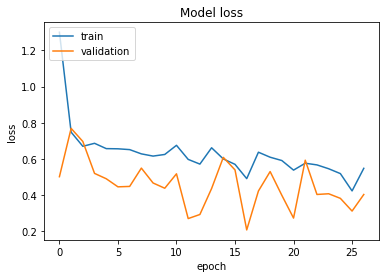

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 83.33%
[INFO] Loss:  0.3744554817676544


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[109  21]
 [ 23   3]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.84      0.83       130
      normal       0.12      0.12      0.12        26

    accuracy                           0.72       156
   macro avg       0.48      0.48      0.48       156
weighted avg       0.71      0.72      0.71       156



In [33]:
from tensorflow.keras.applications import MobileNet
MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(MobileNet,'MobileNet.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 14s 531ms/step - loss: 4.6792 - accuracy: 0.5789 - auc_12: 0.6078 - cohen_kappa: -0.7147 - f1_score: 0.4949 - precision_12: 0.5789 - recall_12: 0.5789 - val_loss: 0.4064 - val_accuracy: 0.8281 - val_auc_12: 0.8933 - val_cohen_kappa: -0.2609 - val_f1_score: 0.5847 - val_precision_12: 0.8281 - val_recall_12: 0.8281

Epoch 00001: val_loss improved from inf to 0.40637, saving model to xception.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 8s 403ms/step - loss: 0.9805 - accuracy: 0.5855 - auc_12: 0.6532 - cohen_kappa: -0.6746 - f1_score: 0.4856 - precision_12: 0.5855 - recall_12: 0.5855 - val_loss: 0.3853 - val_accuracy: 0.8750 - val_auc_12: 0.9131 - val_cohen_kappa: -0.1327 - val_f1_score: 0.4667 - val_precision_12: 0.8750 - val_recall_12: 0.8750

Epoch 00002: val_loss improved from 0.40637 to 0.38533, saving model to xception.h5
Epoch 3/100
19/19 [==============================] - 8s 435ms/step - loss: 0.8104 - accuracy: 0.5559 - auc_12: 0.6201 - cohen_kappa: -0.7186 - f1_score: 0.4690 - precision_12: 0.5559 - recall_12: 0.5559 - val_loss: 1.0341 - val_accuracy: 0.2188 - val_auc_12: 0.2908 - val_cohen_kappa: -0.9826 - val_f1_score: 0.2118 - val_precision_12: 0.2188 - val_recall_12: 0.2188

Epoch 00003: val_loss did not improve from 0.38533
Epoch 4/100
19/19 [==============================] - 8s 408ms/step - loss: 0.7662 - accuracy: 0.4967 - auc_12: 0.4790 - cohen_kap

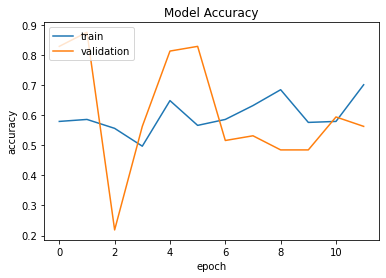

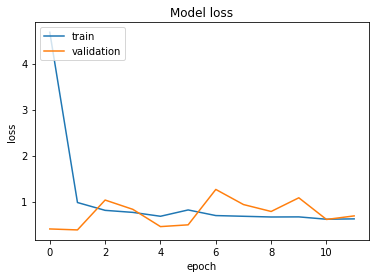

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 82.69%
[INFO] Loss:  0.5611621141433716


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[129   1]
 [ 26   0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.99      0.91       130
      normal       0.00      0.00      0.00        26

    accuracy                           0.83       156
   macro avg       0.42      0.50      0.45       156
weighted avg       0.69      0.83      0.75       156



In [34]:
from tensorflow.keras.applications import Xception
xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(xception,'xception.h5')

87924736/87910968 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 14s 478ms/step - loss: 32.4876 - accuracy: 0.4375 - auc_13: 0.4363 - cohen_kappa: -0.8674 - f1_score: 0.3945 - precision_13: 0.4375 - recall_13: 0.4375 - val_loss: 10.0170 - val_accuracy: 0.1719 - val_auc_13: 0.1719 - val_cohen_kappa: -0.9426 - val_f1_score: 0.1467 - val_precision_13: 0.1719 - val_recall_13: 0.1719

Epoch 00001: val_loss improved from inf to 10.01699, saving model to Inception.h5
Epoch 2/100
19/19 [==============================] - 8s 447ms/step - loss: 2.1837 - accuracy: 0.4638 - auc_13: 0.4465 - cohen_kappa: -0.8735 - f1_score: 0.4250 - precision_13: 0.4638 - recall_13: 0.4638 - val_loss: 2.4492 - val_accuracy: 0.2188 - val_auc_13: 0.1960 - val_cohen_kappa: -0.9826 - val_f1_score: 0.2118 - val_precision_13: 0.2188 - val_recall_13: 0.2188

Epoch 00002: val_loss improved from 10.01699 to 2.44916, saving model to Inception.h5
Epoch 3/100
19/19 [==============================] - 7s 385ms/step - loss: 1.0079 - accuracy:

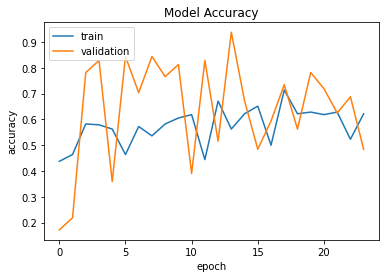

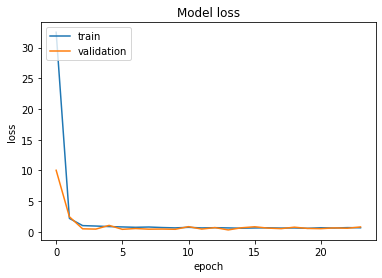

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 83.33%
[INFO] Loss:  0.44102394580841064


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[119  11]
 [ 19   7]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.86      0.92      0.89       130
      normal       0.39      0.27      0.32        26

    accuracy                           0.81       156
   macro avg       0.63      0.59      0.60       156
weighted avg       0.78      0.81      0.79       156



In [35]:
from tensorflow.keras.applications import InceptionV3
Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(Inception,'Inception.h5')

29097984/29084464 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 18s 511ms/step - loss: 1.6256 - accuracy: 0.5263 - auc_14: 0.5381 - cohen_kappa: -0.7458 - f1_score: 0.4456 - precision_14: 0.5263 - recall_14: 0.5263 - val_loss: 0.6124 - val_accuracy: 0.6875 - val_auc_14: 0.7396 - val_cohen_kappa: -0.5193 - val_f1_score: 0.5429 - val_precision_14: 0.6875 - val_recall_14: 0.6875

Epoch 00001: val_loss improved from inf to 0.61244, saving model to DenseNet.h5
Epoch 2/100
19/19 [==============================] - 8s 415ms/step - loss: 0.7912 - accuracy: 0.6579 - auc_14: 0.6787 - cohen_kappa: -0.5831 - f1_score: 0.5356 - precision_14: 0.6579 - recall_14: 0.6579 - val_loss: 0.6458 - val_accuracy: 0.5625 - val_auc_14: 0.6547 - val_cohen_kappa: -0.7886 - val_f1_score: 0.5039 - val_precision_14: 0.5625 - val_recall_14: 0.5625

Epoch 00002: val_loss did not improve from 0.61244
Epoch 3/100
19/19 [==============================] - 8s 424ms/step - loss: 0.6360 - accuracy: 0.6941 - auc_14: 0.7441 - cohen_kappa:

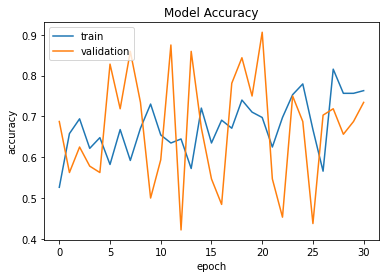

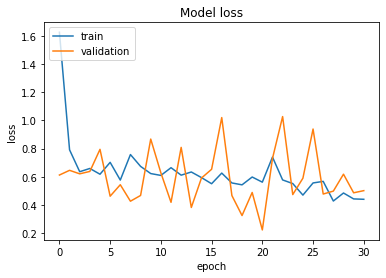

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 85.26%
[INFO] Loss:  0.3204320967197418


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[115  15]
 [ 24   2]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.88      0.86       130
      normal       0.12      0.08      0.09        26

    accuracy                           0.75       156
   macro avg       0.47      0.48      0.47       156
weighted avg       0.71      0.75      0.73       156



In [36]:
from tensorflow.keras.applications import DenseNet121
DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(DenseNet,'DenseNet.h5')

219070464/219055592 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 23s 611ms/step - loss: 108.6626 - accuracy: 0.5987 - auc_15: 0.5960 - cohen_kappa: -0.7068 - f1_score: 0.5154 - precision_15: 0.5987 - recall_15: 0.5987 - val_loss: 49.6520 - val_accuracy: 0.1719 - val_auc_15: 0.1719 - val_cohen_kappa: -0.9426 - val_f1_score: 0.1467 - val_precision_15: 0.1719 - val_recall_15: 0.1719

Epoch 00001: val_loss improved from inf to 49.65198, saving model to InceptionResNet.h5
Epoch 2/100
19/19 [==============================] - 8s 428ms/step - loss: 13.0869 - accuracy: 0.5329 - auc_15: 0.5154 - cohen_kappa: -0.7759 - f1_score: 0.4654 - precision_15: 0.5329 - recall_15: 0.5329 - val_loss: 5.8028 - val_accuracy: 0.1562 - val_auc_15: 0.1609 - val_cohen_kappa: -0.9523 - val_f1_score: 0.1351 - val_precision_15: 0.1562 - val_recall_15: 0.1562

Epoch 00002: val_loss improved from 49.65198 to 5.80283, saving model to InceptionResNet.h5
Epoch 3/100
19/19 [==============================] - 8s 426ms/step - loss: 4.52

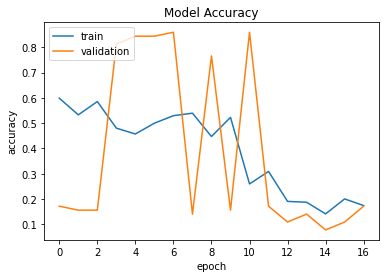

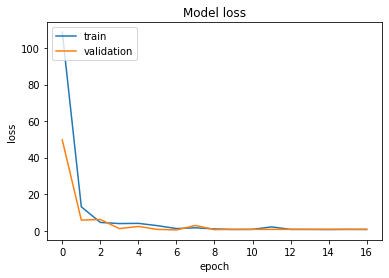

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 83.33%
[INFO] Loss:  0.49639853835105896


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[130   0]
 [ 26   0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      1.00      0.91       130
      normal       0.00      0.00      0.00        26

    accuracy                           0.83       156
   macro avg       0.42      0.50      0.45       156
weighted avg       0.69      0.83      0.76       156



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:

from tensorflow.keras.applications import InceptionResNetV2
InceptionResNet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(InceptionResNet,'InceptionResNet.h5')

258088960/258076736 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 33s 758ms/step - loss: 0.6793 - accuracy: 0.6743 - auc_16: 0.7025 - cohen_kappa: -0.7108 - f1_score: 0.6081 - precision_16: 0.6743 - recall_16: 0.6743 - val_loss: 0.3737 - val_accuracy: 0.7969 - val_auc_16: 0.9119 - val_cohen_kappa: -0.5396 - val_f1_score: 0.7102 - val_precision_16: 0.7969 - val_recall_16: 0.7969

Epoch 00001: val_loss improved from inf to 0.37367, saving model to EfficientNetB7.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 9s 479ms/step - loss: 0.5880 - accuracy: 0.7039 - auc_16: 0.7978 - cohen_kappa: -0.7610 - f1_score: 0.6575 - precision_16: 0.7039 - recall_16: 0.7039 - val_loss: 0.4100 - val_accuracy: 0.7656 - val_auc_16: 0.8870 - val_cohen_kappa: -0.6978 - val_f1_score: 0.7149 - val_precision_16: 0.7656 - val_recall_16: 0.7656

Epoch 00002: val_loss did not improve from 0.37367
Epoch 3/100
19/19 [==============================] - 9s 476ms/step - loss: 0.5123 - accuracy: 0.6579 - auc_16: 0.7763 - cohen_kappa: -0.7685 - f1_score: 0.6064 - precision_16: 0.6579 - recall_16: 0.6579 - val_loss: 0.1926 - val_accuracy: 0.9375 - val_auc_16: 0.9822 - val_cohen_kappa: -0.3187 - val_f1_score: 0.8707 - val_precision_16: 0.9375 - val_recall_16: 0.9375

Epoch 00003: val_loss improved from 0.37367 to 0.19262, saving model to EfficientNetB7.h5
Epoch 4/100
19/19 [==============================] - 9s 471ms/step - loss: 0.5568 - accuracy: 0.7237 - auc_16: 0.8220 - coh

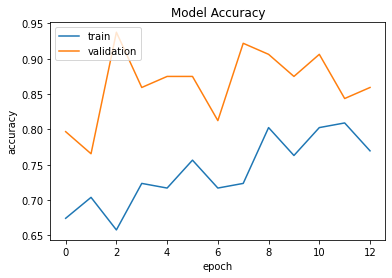

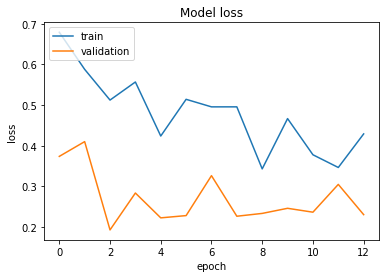

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 89.10%
[INFO] Loss:  0.25654134154319763


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[112  18]
 [ 23   3]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.86      0.85       130
      normal       0.14      0.12      0.13        26

    accuracy                           0.74       156
   macro avg       0.49      0.49      0.49       156
weighted avg       0.72      0.74      0.73       156



In [38]:
from tensorflow.keras.applications import EfficientNetB7
EfficientNetB7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(EfficientNetB7,'EfficientNetB7.h5') 

94781440/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 13s 480ms/step - loss: 1.3112 - accuracy: 0.5921 - auc_17: 0.6156 - cohen_kappa: -0.7685 - f1_score: 0.5307 - precision_17: 0.5921 - recall_17: 0.5921 - val_loss: 0.3775 - val_accuracy: 0.8750 - val_auc_17: 0.9254 - val_cohen_kappa: -0.3980 - val_f1_score: 0.7804 - val_precision_17: 0.8750 - val_recall_17: 0.8750

Epoch 00001: val_loss improved from inf to 0.37755, saving model to ResNet50.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 8s 404ms/step - loss: 0.5925 - accuracy: 0.6908 - auc_17: 0.7588 - cohen_kappa: -0.6746 - f1_score: 0.6162 - precision_17: 0.6908 - recall_17: 0.6908 - val_loss: 0.3651 - val_accuracy: 0.7500 - val_auc_17: 0.9009 - val_cohen_kappa: -0.4382 - val_f1_score: 0.5897 - val_precision_17: 0.7500 - val_recall_17: 0.7500

Epoch 00002: val_loss improved from 0.37755 to 0.36509, saving model to ResNet50.h5
Epoch 3/100
19/19 [==============================] - 8s 442ms/step - loss: 0.6234 - accuracy: 0.6513 - auc_17: 0.7579 - cohen_kappa: -0.7304 - f1_score: 0.5870 - precision_17: 0.6513 - recall_17: 0.6513 - val_loss: 0.3600 - val_accuracy: 0.8125 - val_auc_17: 0.9194 - val_cohen_kappa: -0.4382 - val_f1_score: 0.6923 - val_precision_17: 0.8125 - val_recall_17: 0.8125

Epoch 00003: val_loss improved from 0.36509 to 0.36003, saving model to ResNet50.h5
Epoch 4/100
19/19 [==============================] - 8s 407ms/step - loss: 0.5199 - accuracy: 0.

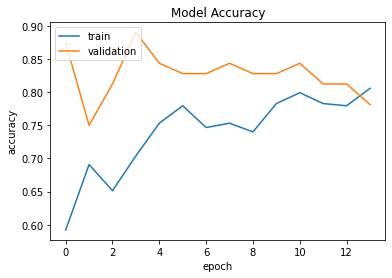

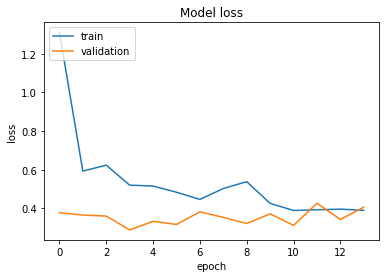

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 87.82%
[INFO] Loss:  0.29441189765930176


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[114  16]
 [ 23   3]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.88      0.85       130
      normal       0.16      0.12      0.13        26

    accuracy                           0.75       156
   macro avg       0.50      0.50      0.49       156
weighted avg       0.72      0.75      0.73       156



In [44]:
from tensorflow.keras.applications import ResNet50
ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(ResNet50,'ResNet50.h5') 

# 3 Class

In [45]:
train_data_dir = '../input/breastcancerlaisonsplit/split - 3/split - 3/train'
validation_data_dir = '../input/breastcancerlaisonsplit/split - 3/split - 3/val'
test_Data_dir=  '../input/breastcancerlaisonsplit/split - 3/split - 3/val'

num_classes = 3

In [46]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory( validation_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
test_generator=test_datagen.flow_from_directory( test_Data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')

Found 625 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 155 images belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 36s 2s/step - loss: 1.3178 - accuracy: 0.4360 - auc_18: 0.6124 - cohen_kappa: 0.0716 - f1_score: 0.3585 - precision_18: 0.4955 - recall_18: 0.3806 - val_loss: 0.9494 - val_accuracy: 0.6250 - val_auc_18: 0.7180 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.2564 - val_precision_18: 0.6250 - val_recall_18: 0.6250

Epoch 00001: val_loss improved from inf to 0.94943, saving model to MobileNet.h5
Epoch 2/100
19/19 [==============================] - 8s 421ms/step - loss: 1.0942 - accuracy: 0.4046 - auc_18: 0.5944 - cohen_kappa: 0.1173 - f1_score: 0.3775 - precision_18: 0.5849 - recall_18: 0.1020 - val_loss: 1.1402 - val_accuracy: 0.2344 - val_auc_18: 0.4218 - val_cohen_kappa: -0.0100 - val_f1_score: 0.2228 - val_precision_18: 0.5000 - val_recall_18: 0.0156

Epoch 00002: val_loss did not improve from 0.94943
Epoch 3/100
19/19 [==============================] - 7s 372ms/step - loss: 1.0990 - accuracy: 0.4740 - auc_18: 0.6532 - cohen_kappa: 

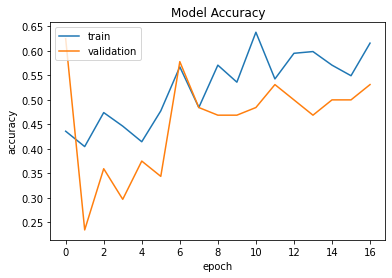

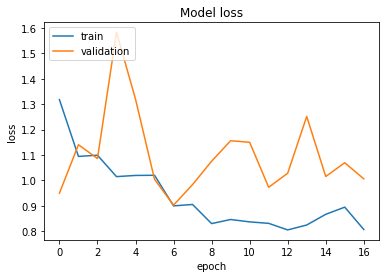

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 57.42%
[INFO] Loss:  0.9441478848457336


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[38 42  7]
 [18 22  2]
 [12 14  0]]
Classification Report
              precision    recall  f1-score   support

      benign       0.56      0.44      0.49        87
   malignant       0.28      0.52      0.37        42
      normal       0.00      0.00      0.00        26

    accuracy                           0.39       155
   macro avg       0.28      0.32      0.29       155
weighted avg       0.39      0.39      0.37       155



In [47]:
from tensorflow.keras.applications import MobileNet
MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(MobileNet,'MobileNet.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 13s 508ms/step - loss: 1.7415 - accuracy: 0.4429 - auc_19: 0.6263 - cohen_kappa: 0.0966 - f1_score: 0.3797 - precision_19: 0.4739 - recall_19: 0.3460 - val_loss: 1.0237 - val_accuracy: 0.3750 - val_auc_19: 0.6545 - val_cohen_kappa: 0.0903 - val_f1_score: 0.2744 - val_precision_19: 0.4000 - val_recall_19: 0.3438

Epoch 00001: val_loss improved from inf to 1.02371, saving model to ResNet50.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 8s 404ms/step - loss: 1.1046 - accuracy: 0.4638 - auc_19: 0.6506 - cohen_kappa: 0.1903 - f1_score: 0.4502 - precision_19: 0.5000 - recall_19: 0.3980 - val_loss: 0.9148 - val_accuracy: 0.5938 - val_auc_19: 0.7728 - val_cohen_kappa: 0.2958 - val_f1_score: 0.5470 - val_precision_19: 0.7667 - val_recall_19: 0.3594

Epoch 00002: val_loss improved from 1.02371 to 0.91484, saving model to ResNet50.h5
Epoch 3/100
19/19 [==============================] - 8s 437ms/step - loss: 0.8772 - accuracy: 0.5855 - auc_19: 0.7792 - cohen_kappa: 0.3641 - f1_score: 0.5603 - precision_19: 0.6608 - recall_19: 0.4934 - val_loss: 1.3093 - val_accuracy: 0.2969 - val_auc_19: 0.5703 - val_cohen_kappa: 0.0834 - val_f1_score: 0.2696 - val_precision_19: 0.2830 - val_recall_19: 0.2344

Epoch 00003: val_loss did not improve from 0.91484
Epoch 4/100
19/19 [==============================] - 8s 408ms/step - loss: 0.8630 - accuracy: 0.5625 - auc_19: 0.7736 - cohen_kappa: 

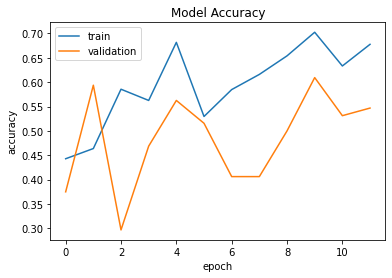

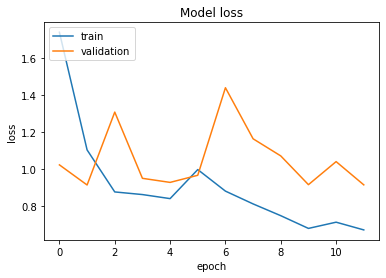

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 63.23%
[INFO] Loss:  0.8871983885765076


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[35 19 33]
 [26  7  9]
 [15  5  6]]
Classification Report
              precision    recall  f1-score   support

      benign       0.46      0.40      0.43        87
   malignant       0.23      0.17      0.19        42
      normal       0.12      0.23      0.16        26

    accuracy                           0.31       155
   macro avg       0.27      0.27      0.26       155
weighted avg       0.34      0.31      0.32       155



In [48]:
from tensorflow.keras.applications import ResNet50
ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(ResNet50,'ResNet50.h5') 

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 33s 776ms/step - loss: 1.2072 - accuracy: 0.3633 - auc_20: 0.5745 - cohen_kappa: 0.0509 - f1_score: 0.3397 - precision_20: 0.4236 - recall_20: 0.2111 - val_loss: 0.9049 - val_accuracy: 0.5938 - val_auc_20: 0.8007 - val_cohen_kappa: 0.2650 - val_f1_score: 0.4740 - val_precision_20: 0.7727 - val_recall_20: 0.2656

Epoch 00001: val_loss improved from inf to 0.90488, saving model to EfficientNetB7.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 9s 486ms/step - loss: 0.8903 - accuracy: 0.5433 - auc_20: 0.7475 - cohen_kappa: 0.2941 - f1_score: 0.5104 - precision_20: 0.6135 - recall_20: 0.4394 - val_loss: 1.0206 - val_accuracy: 0.2812 - val_auc_20: 0.6157 - val_cohen_kappa: -0.0034 - val_f1_score: 0.3137 - val_precision_20: 0.2647 - val_recall_20: 0.1406

Epoch 00002: val_loss did not improve from 0.90488
Epoch 3/100
19/19 [==============================] - 9s 473ms/step - loss: 0.8804 - accuracy: 0.6414 - auc_20: 0.8096 - cohen_kappa: 0.4482 - f1_score: 0.6211 - precision_20: 0.6962 - recall_20: 0.5428 - val_loss: 1.2719 - val_accuracy: 0.4219 - val_auc_20: 0.6224 - val_cohen_kappa: 0.1339 - val_f1_score: 0.4703 - val_precision_20: 0.3864 - val_recall_20: 0.2656

Epoch 00003: val_loss did not improve from 0.90488
Epoch 4/100
19/19 [==============================] - 9s 470ms/step - loss: 0.8038 - accuracy: 0.6217 - auc_20: 0.7984 - cohen_kappa: 0.4335 - f1_score: 0.6143 - prec

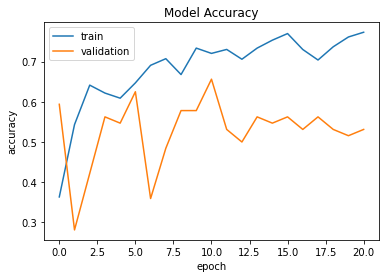

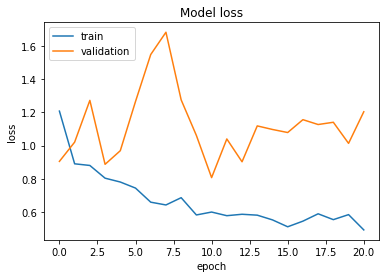

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 54.19%
[INFO] Loss:  1.041555643081665


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[20 42 25]
 [11 22  9]
 [ 7 15  4]]
Classification Report
              precision    recall  f1-score   support

      benign       0.53      0.23      0.32        87
   malignant       0.28      0.52      0.36        42
      normal       0.11      0.15      0.12        26

    accuracy                           0.30       155
   macro avg       0.30      0.30      0.27       155
weighted avg       0.39      0.30      0.30       155



In [49]:
from tensorflow.keras.applications import EfficientNetB7
EfficientNetB7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(EfficientNetB7,'EfficientNetB7.h5') 

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 24s 650ms/step - loss: 185.3554 - accuracy: 0.3487 - auc_21: 0.5132 - cohen_kappa: 0.0056 - f1_score: 0.3146 - precision_21: 0.3487 - recall_21: 0.3487 - val_loss: 21.6113 - val_accuracy: 0.5625 - val_auc_21: 0.6719 - val_cohen_kappa: 0.0000e+00 - val_f1_score: 0.2400 - val_precision_21: 0.5625 - val_recall_21: 0.5625

Epoch 00001: val_loss improved from inf to 21.61127, saving model to InceptionResNet.h5
Epoch 2/100
19/19 [==============================] - 8s 406ms/step - loss: 12.7922 - accuracy: 0.4187 - auc_21: 0.5693 - cohen_kappa: 0.0858 - f1_score: 0.3788 - precision_21: 0.4187 - recall_21: 0.4187 - val_loss: 2.1049 - val_accuracy: 0.1719 - val_auc_21: 0.4362 - val_cohen_kappa: -0.0734 - val_f1_score: 0.1266 - val_precision_21: 0.1746 - val_recall_21: 0.1719

Epoch 00002: val_loss improved from 21.61127 to 2.10489, saving model to InceptionResNet.h5
Epoch 3/100
19/19 [==============================] - 8s 408ms/step - loss: 2.3

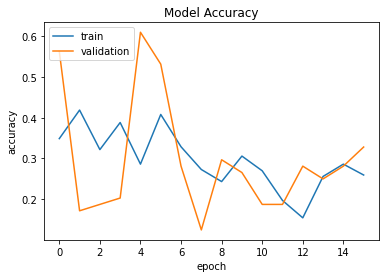

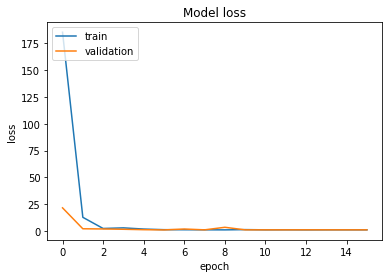

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 47.74%
[INFO] Loss:  1.0412119626998901


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[63  5 19]
 [28  2 12]
 [12  2 12]]
Classification Report
              precision    recall  f1-score   support

      benign       0.61      0.72      0.66        87
   malignant       0.22      0.05      0.08        42
      normal       0.28      0.46      0.35        26

    accuracy                           0.50       155
   macro avg       0.37      0.41      0.36       155
weighted avg       0.45      0.50      0.45       155



In [50]:
from tensorflow.keras.applications import InceptionResNetV2
InceptionResNet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(InceptionResNet,'InceptionResNet.h5')